<a href="https://colab.research.google.com/github/Ran-Dhir-Singh/Pytorch_notebooks/blob/main/PT_02_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network Classification

## 1. Classification data preparation

In [9]:
from sklearn.datasets import make_circles


n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.04,
                   random_state=123)

In [10]:
print(f"X :\n{X[:5]}")
print(f"y :\n{y[:5]}")

X :
[[-0.08027435  1.03268668]
 [-0.83338082  0.55304951]
 [ 0.80414733  0.51726934]
 [ 0.43172569  0.67373476]
 [-0.11905586  0.98386501]]
y :
[0 0 0 1 0]


In [11]:
import pandas as pd

circles = pd.DataFrame({"X1":X[: , 0],
                        "X2":X[: , 1],
                        "label":y})

circles.head()

,X1,X2,label
0,-0.080274,1.032687,0
1,-0.833381,0.553050,0
2,0.804147,0.517269,0
3,0.431726,0.673735,1
4,-0.119056,0.983865,0


In [12]:
circles.label.value_counts()

0    500
1    500
Name: label, dtype: int64

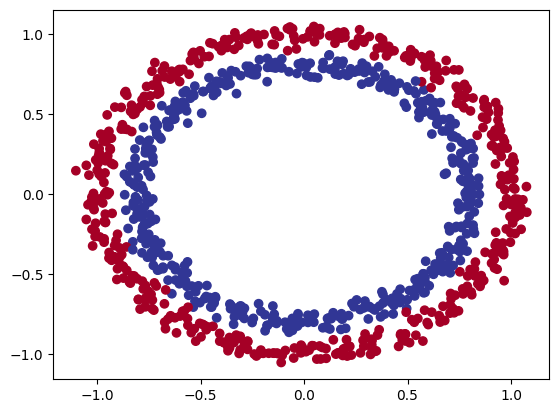

In [13]:
import matplotlib.pyplot as plt

plt.scatter(x=circles["X1"],
            y=circles["X2"],
            c=circles["label"],
            cmap=plt.cm.RdYlBu)
plt.show()

### 1.1 Input and Output shapes

In [14]:
X.shape , y.shape

((1000, 2), (1000,))

### 1.2 Convert data to tensors and create train and test splits

In [16]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


(tensor([[-0.0803,  1.0327],
         [-0.8334,  0.5530],
         [ 0.8041,  0.5173],
         [ 0.4317,  0.6737],
         [-0.1191,  0.9839]]),
 tensor([0., 0., 0., 1., 0.]))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Building model

In [18]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of nn.Module).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.


In [21]:
# 1. Construct a model class using nn.model subclass
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.linear layers capable ofhandling X and y iput and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # 3. Define a forward pass
  def forward(self):
    # return the output of layer 2
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

You can also do the same as above using `nn.Sequential`.

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [22]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
.to(device))

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.5064],
        [-0.3744],
        [-0.3166],
        [-0.1092],
        [-0.0646],
        [-0.6302],
        [-0.4652],
        [-0.4106],
        [-0.5417],
        [-0.3819]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0.])


### 2.1 Setting up loss function and optimizer

In [24]:
loss_fn = nn.BCEWithLogitsLoss()      # has sigmoid build in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [25]:
# accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()   # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train Model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [27]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5064],
        [-0.3744],
        [-0.3166],
        [-0.1092],
        [-0.0646]], grad_fn=<SliceBackward0>)

In [28]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.3760],
        [0.4075],
        [0.4215],
        [0.4727],
        [0.4839]], grad_fn=<SigmoidBackward0>)

In [29]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

### 3.2 Building a Trainig and testing loop